# Detección y Clasificación de Objetos con ResNet50

## Presentado por:
- Natalia Moreno Montoya - 2230434
- Liseth Esmeralda Erazo Varela - 2231713
- Valentina Bueno Collazos - 2230556

## Descripción del Proyecto

Este notebook implementa un modelo de **Transfer Learning** basado en **ResNet50** para resolver dos tareas simultáneas:

1. **Detección de objetos**: Predecir la ubicación del objeto mediante bounding boxes
2. **Clasificación de objetos**: Identificar la clase del objeto detectado (15 clases)

## Características Principales

- **Modelo Base**: ResNet50 preentrenado en ImageNet (~25.6M parámetros)
- **Técnica**: Transfer Learning con congelamiento inicial del base model
- **Arquitectura**: Multi-output model (bbox regressor + classifier)
- **Framework**: TensorFlow 2.x / Keras
- **Formato de Datos**: YOLO format (coordenadas normalizadas)

## Arquitectura del Modelo

```
Input Image (640x640x3)
        ↓
   ResNet50 Base
   (preentrenado, congelado)
        ↓
GlobalAveragePooling2D
        ↓
     ┌──────┴──────┐
     ↓             ↓
BBox Branch    Class Branch
Dense(256)     Dense(512)
Dropout(0.3)   Dropout(0.5)
Dense(128)     Dense(256)
Dense(4)       Dense(15)
Sigmoid        Softmax
     ↓             ↓
bbox_output    class_output
[x,y,w,h]      [15 probs]
```

### Descarga Parcial del Dataset
Se utiliza **sparse checkout** de Git para descargar únicamente la carpeta `proyecto_IA_v2` del repositorio, optimizando tiempo y espacio en disco.

In [1]:
!mkdir tmp_repo && cd tmp_repo

!git init
!git remote add origin https://github.com/natam226/proyecto_IA.git
!git config core.sparseCheckout true

!echo "proyecto_IA_v2/" >> .git/info/sparse-checkout

!git pull origin main

!mv proyecto_IA_v2 /content/
!cd /content && rm -rf tmp_repo

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 367 (delta 0), reused 6 (delta 0), pack-reused 361 (from 3)
Receiving objects: 100% (367/367), 397.26 MiB | 26.87 MiB/s, done.
From https://github.com/natam226/proyecto_IA
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main
Updating files: 100% (339/339), done.
mv: 'proyecto_IA

## Configuración Inicial e Imports

### Librerías Importadas

- **TensorFlow/Keras**: Framework principal de deep learning
- **ResNet50**: Modelo base preentrenado
- **NumPy**: Operaciones numéricas
- **Matplotlib**: Visualización de resultados

### Parámetros Configurables

| Parámetro | Valor Actual | Descripción | Recomendaciones |
|-----------|--------------|-------------|-----------------|
| `PATH_BASE` | Ruta del proyecto | Directorio raíz del proyecto | Actualizar según tu sistema |
| `IMG_SIZE` | 640 | Tamaño de entrada (640x640) | 416 para GPUs pequeñas, 640-800 para GPUs potentes |
| `BATCH_SIZE` | 8 | Imágenes por batch | 4 para 4GB VRAM, 8-16 para 8GB+, 2 para CPU |
| `EPOCHS` | 30 | Número máximo de épocas | 30-50 para Transfer Learning |
| `NUM_CLASSES` | 15 | Número de clases | Debe coincidir con tu dataset |
| `LEARNING_RATE` | 0.0001 | Tasa de aprendizaje | 1e-4 es estándar, reducir si hay inestabilidad |


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- 1. CONFIGURACIÓN INICIAL ---
# Configuración de rutas - ajustar según tu entorno
PATH_BASE = '/content/proyecto_IA_v2'
PATH_TRAIN = os.path.join(PATH_BASE, 'train')
PATH_VAL = os.path.join(PATH_BASE, 'val')

IMG_SIZE = 640      # ResNet50 funciona bien con este tamaño
BATCH_SIZE = 8      # Reducir batch size para evitar problemas de memoria
EPOCHS = 30         # El Transfer Learning suele requerir menos épocas

NUM_CLASSES = 15

LEARNING_RATE = 0.0001 # Tasa de aprendizaje reducida para estabilidad

print(f"Path base: {PATH_BASE}")
print(f"Path train: {PATH_TRAIN}")
# print(f"Path val: {PATH_VAL}")
print(f"Train exists: {os.path.exists(PATH_TRAIN)}")
print(f"Val exists: {os.path.exists(PATH_VAL)}")

Path base: /content/proyecto_IA_v2
Path train: /content/proyecto_IA_v2/train
Train exists: True
Val exists: True


## Pipeline de Datos, Modelo y Entrenamiento

Esta celda es el corazón del notebook. Realiza las siguientes operaciones:

### 1️. Carga de Datos (`load_data`)

**Función**: Carga rutas de imágenes y parsea archivos de etiquetas YOLO

**Características**:
- Validación de existencia de directorios
- Parseo de formato YOLO (class x_center y_center width height)
- Manejo de errores para etiquetas inválidas
- Retorna listas de rutas y diccionarios de etiquetas

**Salida esperada**:
```
Loaded 100 images from train
Loaded 20 images from val
```

---

### 2. Generador de Datos (`data_generator`)

**Función**: Crea tf.data.Dataset optimizado para entrenamiento

**Pipeline de Preprocesamiento**:

1. **Lectura de imagen**: `tf.io.read_file` + `decode_image`
2. **Redimensionamiento**: Resize a IMG_SIZE x IMG_SIZE
3. **Normalización ImageNet**: 
   - Resta media por canal: [103.939, 116.779, 123.68]
   - Convierte RGB → BGR
4. **Shuffling**: Solo en entrenamiento (buffer aleatorio)
5. **Batching**: Agrupa imágenes en batches
6. **Prefetching**: Carga siguiente batch mientras se procesa el actual

**Optimizaciones**:
- `num_parallel_calls=AUTOTUNE`: Paralelización automática
- `prefetch()`: Solapamiento de I/O y computación
- Formato de salida: `{'bbox_output': [x,y,w,h], 'class_output': class_id}`

---

### 3️. Construcción del Modelo (`build_resnet_model`)

**Arquitectura Multi-Output**:

#### Base Model: ResNet50
- Preentrenado en ImageNet (1.4M imágenes, 1000 clases)
- **Congelado inicialmente** (`trainable=False`)
- Sin clasificador top (`include_top=False`)
- Extrae features visuales de alto nivel

#### Global Average Pooling
- Reduce feature maps (20, 20, 2048) → vector (2048,)
- Previene overfitting vs Flatten
- Mantiene información espacial global

#### Rama de Bounding Box (Regresión)
```
Input (2048) 
  → Dense(256, ReLU) 
  → Dropout(0.3) 
  → Dense(128, ReLU) 
  → Dense(4, Sigmoid)
Output: [x_center, y_center, width, height]
```
- **Dropout 0.3**: Regularización moderada
- **Activación Sigmoid**: Mantiene valores en [0, 1]
- **Pérdida**: Mean Squared Error (MSE)

#### Rama de Clasificación
```
Input (2048) 
  → Dense(512, ReLU) 
  → Dropout(0.5) 
  → Dense(256, ReLU) 
  → Dense(15, Softmax)
Output: [prob_clase_0, prob_clase_1, ..., prob_clase_14]
```
- **Dropout 0.5**: Regularización fuerte (mayor riesgo de overfitting)
- **Activación Softmax**: Distribución de probabilidad
- **Pérdida**: Sparse Categorical Crossentropy

---

### 4. Compilación del Modelo

**Funciones de Pérdida**:
```python
loss_total = 1.0 * MSE(bbox) + 1.0 * CrossEntropy(class)
```

**Métricas**:
- Clasificación: `accuracy` (% de predicciones correctas)
- BBox: `mae` (error absoluto medio en coordenadas)

**Optimizador**: Adam
- Learning rate adaptativo por parámetro
- Momentum + RMSprop
- Ideal para Transfer Learning

---

### 5. Callbacks (Detención y Ajuste Automático)

#### EarlyStopping
- **Monitor**: `val_loss` (pérdida en validación)
- **Patience**: 10 épocas sin mejora
- **Acción**: Detiene entrenamiento y restaura mejores pesos
- **Propósito**: Prevenir overfitting

#### ReduceLROnPlateau
- **Monitor**: `val_loss`
- **Factor**: 0.5 (reduce LR a la mitad)
- **Patience**: 5 épocas sin mejora
- **Min LR**: 1e-7
- **Propósito**: Ajuste fino cuando el modelo se estanca

---

### 6. Entrenamiento

**Proceso**:
1. Forward pass en batch de entrenamiento
2. Cálculo de pérdidas (bbox + clasificación)
3. Backpropagation y actualización de pesos
4. Validación después de cada época
5. Callbacks evalúan si detener o ajustar LR

**Salida por Época**:
```
Epoch 10/30
13/13 [======] - 15s 1s/step
- loss: 1.234                        # Pérdida total
- bbox_output_loss: 0.045            # Pérdida bbox (MSE)
- class_output_loss: 1.189           # Pérdida clasificación
- bbox_output_mae: 0.156             # Error promedio bbox
- class_output_accuracy: 0.650       # 65% accuracy
- val_loss: 1.456                    # Pérdida validación
- val_bbox_output_loss: 0.052
- val_class_output_loss: 1.404
- val_bbox_output_mae: 0.178
- val_class_output_accuracy: 0.550   # 55% accuracy
```

---

In [ ]:
# --- CARGADOR Y GENERADOR DE DATOS ---
def load_data(data_path):
    """Carga las rutas de imágenes y sus etiquetas desde el directorio especificado"""
    image_dir = os.path.join(data_path, 'images')
    label_dir = os.path.join(data_path, 'labels')
    image_paths, labels = [], []

    if not os.path.exists(image_dir):
        print(f"WARNING: Image directory not found: {image_dir}")
        return [], []

    if not os.path.exists(label_dir):
        print(f"WARNING: Label directory not found: {label_dir}")
        return [], []

    for filename in sorted(os.listdir(image_dir)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(image_dir, filename)
            label_filename = os.path.splitext(filename)[0] + '.txt'
            label_path = os.path.join(label_dir, label_filename)

            if os.path.exists(label_path):
                image_paths.append(img_path)
                with open(label_path, 'r') as f:
                    line = f.readline().strip().split()
                    if len(line) >= 5:
                        labels.append({
                            'class_id': int(line[0]),
                            'bbox': [float(p) for p in line[1:5]]
                        })
                    else:
                        print(f"WARNING: Invalid label format in {label_path}")

    print(f"Loaded {len(image_paths)} images from {data_path}")
    return image_paths, labels

def data_generator(image_paths, labels, batch_size, img_size=640, is_training=True):
    """Genera batches de datos para entrenamiento o validación"""

    def preprocess_fn(image_path, class_id, bbox):
        """Función de preprocesamiento para cada imagen"""
        # Leer y decodificar imagen
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.cast(img, tf.float32)

        # Redimensionar
        img = tf.image.resize(img, [img_size, img_size])

        # Preprocesamiento ResNet (normalización ImageNet)
        img = tf.keras.applications.resnet.preprocess_input(img)

        # Convertir tipos
        bbox = tf.cast(bbox, tf.float32)
        class_id = tf.cast(class_id, tf.int32)

        return img, {'bbox_output': bbox, 'class_output': class_id}

    # Crear dataset desde las listas
    image_paths_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    class_ids_ds = tf.data.Dataset.from_tensor_slices([l['class_id'] for l in labels])
    bboxes_ds = tf.data.Dataset.from_tensor_slices([l['bbox'] for l in labels])

    # Combinar los datasets
    dataset = tf.data.Dataset.zip((image_paths_ds, class_ids_ds, bboxes_ds))

    # Shuffle si es entrenamiento
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(image_paths))

    # Map de preprocesamiento
    dataset = dataset.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch y prefetch
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# --- CONSTRUCCIÓN DEL MODELO ---
def build_resnet_model(num_classes, img_size=640):
    """Construye modelo ResNet50 con dos salidas: bbox y clasificación"""
    # Cargar ResNet50 preentrenado (sin la capa superior)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )

    # Congelar el modelo base inicialmente (Transfer Learning)
    base_model.trainable = False

    inputs = base_model.input
    x = base_model.output

    # Global Average Pooling para reducir dimensionalidad
    x = layers.GlobalAveragePooling2D()(x)

    # Rama de Regresión de Bounding Box
    bbox_branch = layers.Dense(256, activation='relu', name='bbox_dense1')(x)
    bbox_branch = layers.Dropout(0.3)(bbox_branch)
    bbox_branch = layers.Dense(128, activation='relu', name='bbox_dense2')(bbox_branch)
    bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(bbox_branch)

    # Rama de Clasificación
    class_branch = layers.Dense(512, activation='relu', name='class_dense1')(x)
    class_branch = layers.Dropout(0.5)(class_branch)
    class_branch = layers.Dense(256, activation='relu', name='class_dense2')(class_branch)
    class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(class_branch)

    # Crear modelo con dos salidas
    model = keras.Model(inputs=inputs, outputs=[bbox_output, class_output])

    return model

# --- CARGAR DATOS ---
print("\n--- CARGANDO DATOS ---")
train_images, train_labels = load_data(PATH_TRAIN)
val_images, val_labels = load_data(PATH_VAL)

if len(train_images) == 0 or len(val_images) == 0:
    print("ERROR: No se pudieron cargar los datos. Verifica las rutas.")
else:
    print(f"Datos de entrenamiento: {len(train_images)} imágenes")
    print(f"Datos de validación: {len(val_images)} imágenes")

    # Crear generadores
    train_dataset = data_generator(train_images, train_labels, BATCH_SIZE, IMG_SIZE, is_training=True)
    val_dataset = data_generator(val_images, val_labels, BATCH_SIZE, IMG_SIZE, is_training=False)

    # --- CONSTRUCCIÓN Y COMPILACIÓN DEL MODELO ---
    print("\n--- CONSTRUYENDO MODELO ---")
    model = build_resnet_model(NUM_CLASSES, IMG_SIZE)
    model.summary()

    # Definir pérdidas y pesos
    losses = {
        "bbox_output": tf.keras.losses.MeanSquaredError(),
        "class_output": tf.keras.losses.SparseCategoricalCrossentropy()
    }

    loss_weights = {
        "bbox_output": 1.0,
        "class_output": 1.0
    }

    # Compilar modelo
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss=losses,
        loss_weights=loss_weights,
        metrics={
            "class_output": ["accuracy"],
            "bbox_output": ["mae"]
        }
    )

    # --- CALLBACKS ---
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7
        )
    ]

    # --- ENTRENAMIENTO ---
    print("\n--- INICIANDO ENTRENAMIENTO (TRANSFER LEARNING) ---")
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    print("\n--- ENTRENAMIENTO COMPLETADO ---")


--- CARGANDO DATOS ---
Loaded 148 images from /content/proyecto_IA_v2/train
Loaded 9 images from /content/proyecto_IA_v2/val
Datos de entrenamiento: 148 imágenes
Datos de validación: 9 imágenes

--- CONSTRUYENDO MODELO ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 640, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 646, 646,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 320, 320,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 320, 320,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 320, 320,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 322, 322,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 160, 160,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 160, 160,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 160, 160,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 160, 160,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 160, 160,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 160, 160,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 160, 160,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 160, 160,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 160, 160,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 160, 160,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 160, 160,  │      1,024 │ conv2_block1_3_c

 Total params: 25,329,939 (96.63 MB)

 Trainable params: 1,742,227 (6.65 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- INICIANDO ENTRENAMIENTO (TRANSFER LEARNING) ---
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - bbox_output_loss: 0.0726 - bbox_output_mae: 0.2163 - class_output_accuracy: 0.5204 - class_output_loss: 1.8835 - loss: 1.9552 - val_bbox_output_loss: 0.0218 - val_bbox_output_mae: 0.1155 - val_class_output_accuracy: 0.7778 - val_class_output_loss: 0.6258 - val_loss: 1.0066 - learning_rate: 1.0000e-04
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 664ms/step - bbox_output_loss: 0.0206 - bbox_output_mae: 0.1065 - class_output_accuracy: 0.6959 - class_output_loss: 1.1848 - loss: 1.2039 - val_bbox_output_loss: 0.0172 - val_bbox_output_mae: 0.1006 - val_class_output_accuracy: 0.7778 - val_class_output_loss: 0.7228 - val_loss: 1.1183 - learning_rate: 1.0000e-04
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 674ms/step - bbox_output_loss: 0.0227 - bbox_output_mae: 0.1051 - class_output_accuracy: 0.6427 - class_output_loss: 1.4190 - loss: 1.4397 - val_bbox_output_loss: 0.0173 - val_bbox_output_mae: 0

## Visualización de Resultados

Esta celda genera visualizaciones para analizar el desempeño del modelo entrenado.

### Gráficas de Métricas (Grid 2x2)

#### 1. Pérdida Total del Modelo (Superior Izquierda)
- **Línea azul**: Loss de entrenamiento
- **Línea naranja**: Loss de validación

#### 2. Precisión de Clasificación (Superior Derecha)
- **Accuracy**: Porcentaje de clases predichas correctamente
- **Meta**: > 70% es bueno, > 85% es excelente

#### 3. Pérdida de Bounding Box - MSE (Inferior Izquierda)
- **MSE**: Error cuadrático medio en coordenadas

#### 4. Error Absoluto Medio de BBox - MAE (Inferior Derecha)
- **MAE**: Error promedio en coordenadas normalizadas
- **Ejemplo**: MAE=0.15 significa error del 15% en posiciones
- **Meta**: < 0.10 (error < 10%)

---

### Visualización de Predicciones

**Función**: `predict_and_visualize(model, image_paths, labels, num_images=5)`

**Características**:
- Muestra 5 imágenes del conjunto de validación
- **Bounding Box Verde**: Ground truth (etiqueta real)
- **Bounding Box Rojo (discontinuo)**: Predicción del modelo

**Proceso Interno**:

1. **Desnormalización de Imágenes**:
   ```python
   # Revertir normalización ImageNet
   img[..., 0] += 103.939  # Canal B
   img[..., 1] += 116.779  # Canal G
   img[..., 2] += 123.68   # Canal R
   img = img[..., ::-1]    # BGR → RGB
   ```

2. **Conversión de Coordenadas**:
   - Entrada: Coordenadas normalizadas [0, 1]
   - Salida: Píxeles absolutos [0, IMG_SIZE]

3. **Dibujo de Bounding Boxes**:
   - Formato: `(x_top_left, y_top_left, width, height)`
   - Conversión: `x1 = (x_center - width/2) * IMG_SIZE`

**Evaluación Visual**:
- ✅ **Boxes superpuestos**: Excelente
- 🟡 **Boxes cercanos**: Bueno
- ❌ **Boxes muy separados**: Necesita más entrenamiento
---

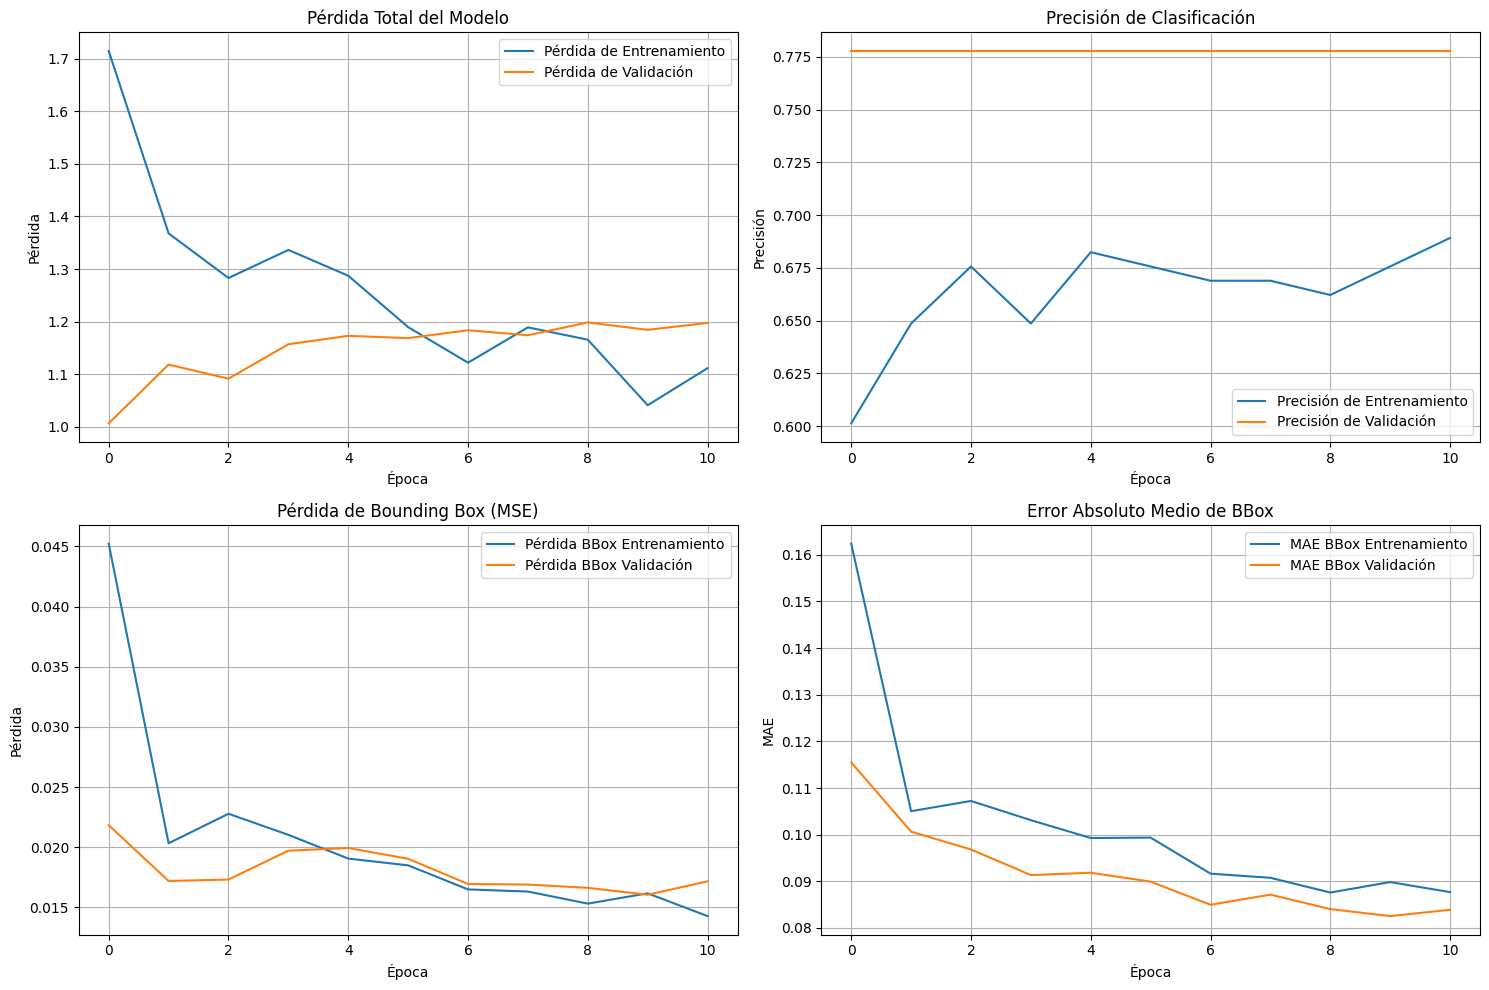


--- VISUALIZANDO PREDICCIONES ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


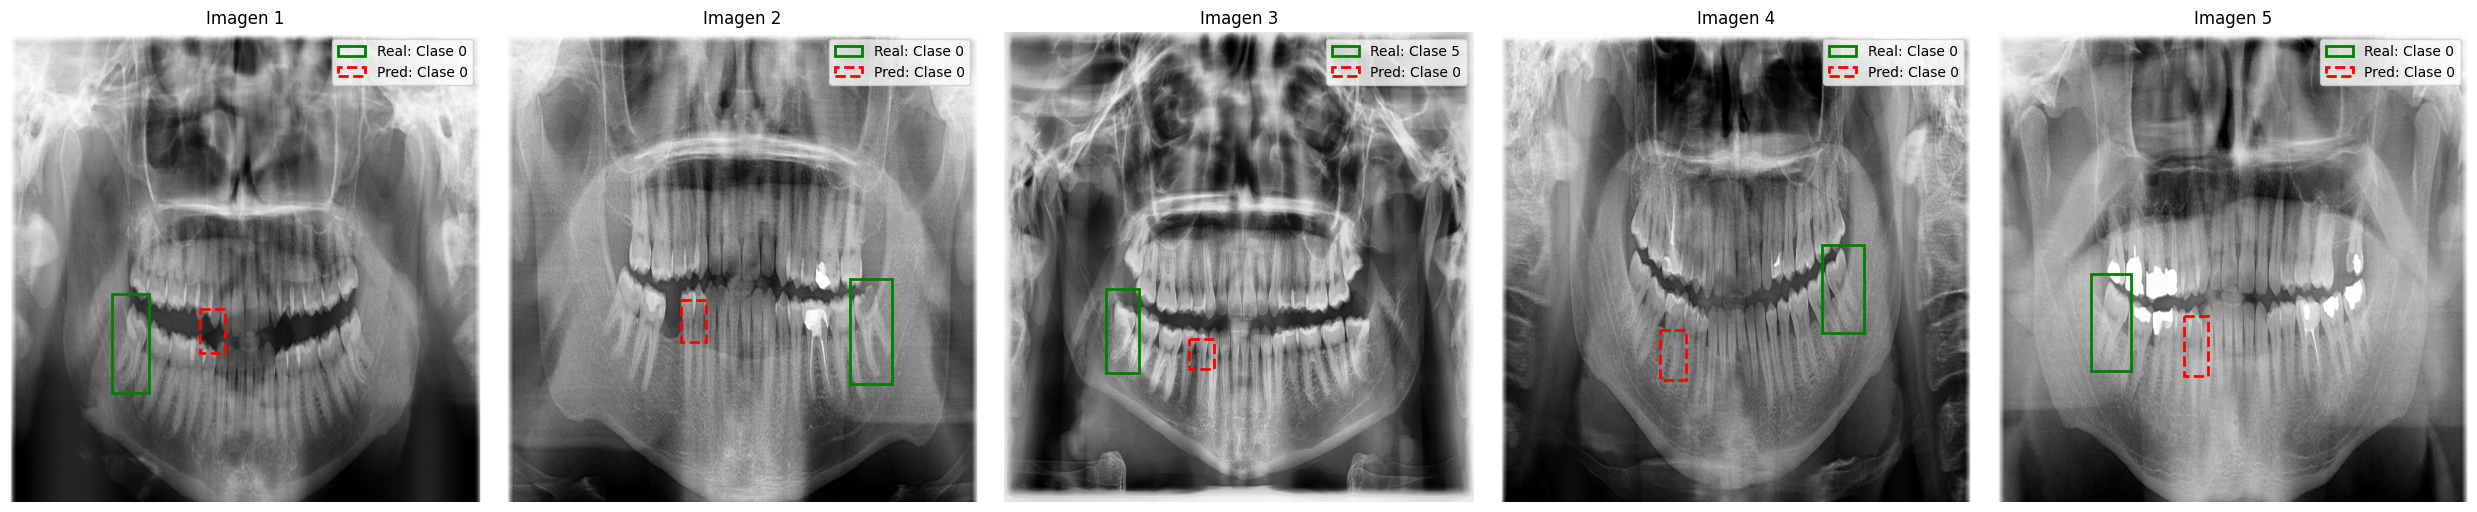

In [4]:
# --- VISUALIZACIÓN DE MÉTRICAS DE ENTRENAMIENTO ---
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Pérdida total
axes[0, 0].plot(history.history['loss'], label='Pérdida de Entrenamiento')
axes[0, 0].plot(history.history['val_loss'], label='Pérdida de Validación')
axes[0, 0].set_title('Pérdida Total del Modelo')
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Pérdida')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Precisión de clasificación
axes[0, 1].plot(history.history['class_output_accuracy'], label='Precisión de Entrenamiento')
axes[0, 1].plot(history.history['val_class_output_accuracy'], label='Precisión de Validación')
axes[0, 1].set_title('Precisión de Clasificación')
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Precisión')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Pérdida de BBox
axes[1, 0].plot(history.history['bbox_output_loss'], label='Pérdida BBox Entrenamiento')
axes[1, 0].plot(history.history['val_bbox_output_loss'], label='Pérdida BBox Validación')
axes[1, 0].set_title('Pérdida de Bounding Box (MSE)')
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Pérdida')
axes[1, 0].legend()
axes[1, 0].grid(True)

# MAE de BBox
axes[1, 1].plot(history.history['bbox_output_mae'], label='MAE BBox Entrenamiento')
axes[1, 1].plot(history.history['val_bbox_output_mae'], label='MAE BBox Validación')
axes[1, 1].set_title('Error Absoluto Medio de BBox')
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# --- VISUALIZACIÓN DE PREDICCIONES ---
def predict_and_visualize(model, image_paths, labels, num_images=5):
    """Visualiza predicciones del modelo sobre imágenes de validación"""

    # Limitar número de imágenes
    num_images = min(num_images, len(image_paths))

    # Crear un pequeño dataset para visualización
    vis_dataset = data_generator(
        image_paths[:num_images],
        labels[:num_images],
        batch_size=num_images,
        img_size=IMG_SIZE,
        is_training=False
    )

    # Obtener un batch
    images_batch, labels_batch = next(iter(vis_dataset))

    # Hacer predicciones
    pred_bboxes, pred_classes_probs = model.predict(images_batch)
    pred_classes = np.argmax(pred_classes_probs, axis=1)

    # Obtener etiquetas reales
    true_bboxes = labels_batch['bbox_output'].numpy()
    true_classes = labels_batch['class_output'].numpy()

    # Desnormalizar imágenes para visualización
    def denormalize_image(img):
        """Desnormaliza la imagen procesada por ResNet"""
        # Revertir la normalización de ImageNet
        img = img.copy()
        img[..., 0] += 103.939
        img[..., 1] += 116.779
        img[..., 2] += 123.68
        img = img[..., ::-1]  # BGR -> RGB
        img = np.clip(img / 255.0, 0, 1)
        return img

    # Visualizar
    fig, axes = plt.subplots(1, num_images, figsize=(5*num_images, 5))
    if num_images == 1:
        axes = [axes]

    for i in range(num_images):
        ax = axes[i]

        # Desnormalizar imagen
        img = denormalize_image(images_batch[i].numpy())
        ax.imshow(img)

        # Convertir coordenadas normalizadas a píxeles
        h, w = IMG_SIZE, IMG_SIZE

        # BBox real (verde)
        x_center, y_center, width, height = true_bboxes[i]
        x1 = int((x_center - width/2) * w)
        y1 = int((y_center - height/2) * h)
        box_w = int(width * w)
        box_h = int(height * h)
        rect_true = patches.Rectangle(
            (x1, y1), box_w, box_h,
            linewidth=2, edgecolor='green', facecolor='none',
            label=f'Real: Clase {true_classes[i]}'
        )
        ax.add_patch(rect_true)

        # BBox predicha (roja)
        x_center, y_center, width, height = pred_bboxes[i]
        x1 = int((x_center - width/2) * w)
        y1 = int((y_center - height/2) * h)
        box_w = int(width * w)
        box_h = int(height * h)
        rect_pred = patches.Rectangle(
            (x1, y1), box_w, box_h,
            linewidth=2, edgecolor='red', facecolor='none', linestyle='--',
            label=f'Pred: Clase {pred_classes[i]}'
        )
        ax.add_patch(rect_pred)

        ax.set_title(f'Imagen {i+1}')
        ax.legend()
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar predicciones
print("\n--- VISUALIZANDO PREDICCIONES ---")
predict_and_visualize(model, val_images, val_labels, num_images=5)

## Evaluación Detallada con Métricas Estándar

Esta celda calcula métricas profesionales de detección de objetos, similares a las usadas en competencias como COCO y PASCAL VOC.

---

### Métricas Calculadas

| Métrica | Descripción | Rango | Interpretación |
|---------|-------------|-------|----------------|
| **mAP@0.5** | Mean Average Precision con IoU≥0.5 | 0-1 | Principal métrica de detección |
| **mAP@0.5:0.95** | mAP promediado desde IoU 0.5 a 0.95 | 0-1 | Métrica COCO (más estricta) |
| **Precision** | TP / (TP + FP) | 0-1 | % de detecciones correctas |
| **Recall** | TP / (TP + FN) | 0-1 | % de objetos encontrados |
| **F1-Score** | Media armónica Precision-Recall | 0-1 | Balance global |

---

In [5]:
# --- EVALUACIÓN DETALLADA DEL MODELO CON MÉTRICAS ESTÁNDAR ---

import pandas as pd
from tqdm import tqdm

print("Iniciando la evaluación detallada del modelo...")

# ------------------------------------------------------------------------------
# FUNCIÓN AUXILIAR PARA CALCULAR INTERSECCIÓN SOBRE UNIÓN (IOU)
# ------------------------------------------------------------------------------
def calculate_iou(box1, box2):
    """Calcula IoU entre dos bounding boxes en formato [x_center, y_center, width, height]"""
    # Convertir de centro+tamaño a min/max
    box1_min_x = box1[0] - box1[2] / 2
    box1_min_y = box1[1] - box1[3] / 2
    box1_max_x = box1[0] + box1[2] / 2
    box1_max_y = box1[1] + box1[3] / 2

    box2_min_x = box2[0] - box2[2] / 2
    box2_min_y = box2[1] - box2[3] / 2
    box2_max_x = box2[0] + box2[2] / 2
    box2_max_y = box2[1] + box2[3] / 2

    # Calcular intersección
    inter_min_x = max(box1_min_x, box2_min_x)
    inter_min_y = max(box1_min_y, box2_min_y)
    inter_max_x = min(box1_max_x, box2_max_x)
    inter_max_y = min(box1_max_y, box2_max_y)

    inter_area = max(0, inter_max_x - inter_min_x) * max(0, inter_max_y - inter_min_y)

    # Calcular unión
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]
    union_area = box1_area + box2_area - inter_area

    # Calcular IoU
    iou = inter_area / union_area if union_area > 0 else 0.0
    return iou

# ------------------------------------------------------------------------------
# RECOLECTAR TODAS LAS PREDICCIONES Y ETIQUETAS REALES
# ------------------------------------------------------------------------------
eval_dataset = val_dataset
all_gt_boxes, all_gt_classes = [], []
all_pred_boxes, all_pred_scores, all_pred_classes = [], [], []

print("Generando predicciones en el conjunto de datos de validación...")
for batch_data in tqdm(eval_dataset):
    images, labels_dict = batch_data
    gt_bboxes = labels_dict['bbox_output']
    gt_classes_ids = labels_dict['class_output']

    # Predicciones
    pred_bboxes, pred_classes_probs = model.predict_on_batch(images)

    # Almacenar para cada imagen en el batch
    for i in range(len(images)):
        all_gt_boxes.append(gt_bboxes[i].numpy())
        all_gt_classes.append(gt_classes_ids[i].numpy())
        all_pred_boxes.append(pred_bboxes[i])
        all_pred_scores.append(np.max(pred_classes_probs[i]))
        all_pred_classes.append(np.argmax(pred_classes_probs[i]))

# ------------------------------------------------------------------------------
# CALCULAR MÉTRICAS (PRECISION, RECALL, MAP)
# ------------------------------------------------------------------------------
def calculate_average_precision(gts, preds, iou_threshold):
    """Calcula Average Precision para una clase específica"""
    # Si no hay predicciones para esta clase, AP es 0
    if not preds:
        return 0.0, 0, 0

    # Si no hay ground truths, todas las predicciones son falsos positivos
    if not gts:
        return 0.0, 0, len(preds)

    # Ordenar predicciones por confianza (score)
    preds = sorted(preds, key=lambda x: x['score'], reverse=True)

    TP = np.zeros(len(preds))
    FP = np.zeros(len(preds))
    num_gt = len(gts)

    # Para cada predicción, verificar si es TP o FP
    for i, pred in enumerate(preds):
        best_iou = 0
        best_gt_idx = -1

        # Encontrar el GT con mayor IoU
        for j, gt in enumerate(gts):
            iou = calculate_iou(pred['box'], gt['box'])
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j

        # Si IoU >= threshold y el GT no ha sido detectado, es TP
        if best_iou >= iou_threshold and not gts[best_gt_idx]['detected']:
            TP[i] = 1
            gts[best_gt_idx]['detected'] = True
        else:
            FP[i] = 1

    # Calcular precision y recall acumulativos
    TP_cumsum = np.cumsum(TP)
    FP_cumsum = np.cumsum(FP)

    recalls = TP_cumsum / num_gt
    precisions = TP_cumsum / (TP_cumsum + FP_cumsum)

    # Agregar puntos extremos para interpolación
    precisions = np.concatenate(([0.], precisions, [0.]))
    recalls = np.concatenate(([0.], recalls, [1.]))

    # Interpolación monotónica decreciente
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i+1])

    # Calcular AP como área bajo la curva
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    ap = np.sum((recalls[indices] - recalls[indices-1]) * precisions[indices])

    total_tp = int(TP_cumsum[-1]) if len(TP_cumsum) > 0 else 0

    return ap, total_tp, len(preds)

print("\nCalculando métricas de detección...")
iou_thresholds = np.linspace(0.5, 0.95, 10)
final_metrics = {
    'mAP50': 0,
    'mAP50-95': 0,
    'total_tp': 0,
    'total_preds': 0,
    'total_gts': 0
}

ap_per_class_50 = []

# Calcular métricas por clase
for c in range(NUM_CLASSES):
    # Ground truths para esta clase
    gts = []
    for i, gt_cls in enumerate(all_gt_classes):
        if gt_cls == c:
            gts.append({
                'box': all_gt_boxes[i],
                'detected': False
            })

    # Predicciones para esta clase
    preds = []
    for i, pred_cls in enumerate(all_pred_classes):
        if pred_cls == c:
            preds.append({
                'box': all_pred_boxes[i],
                'score': all_pred_scores[i]
            })

    # Calcular AP@0.5
    ap50, total_tp, total_preds = calculate_average_precision(
        [g.copy() for g in gts],
        preds,
        0.5
    )
    ap_per_class_50.append(ap50)

    # Acumular totales
    final_metrics['total_tp'] += total_tp
    final_metrics['total_preds'] += total_preds
    final_metrics['total_gts'] += len(gts)

    # Calcular AP para diferentes IoU thresholds
    ap_across_iou = []
    for iou_thresh in iou_thresholds:
        ap, _, _ = calculate_average_precision(
            [g.copy() for g in gts],
            preds,
            iou_thresh
        )
        ap_across_iou.append(ap)

    final_metrics['mAP50-95'] += np.mean(ap_across_iou)

# Promediar métricas
final_metrics['mAP50'] = np.mean(ap_per_class_50)
final_metrics['mAP50-95'] /= NUM_CLASSES

# Calcular Precision y Recall globales
if final_metrics['total_preds'] > 0:
    final_metrics['Precision'] = final_metrics['total_tp'] / final_metrics['total_preds']
else:
    final_metrics['Precision'] = 0.0

if final_metrics['total_gts'] > 0:
    final_metrics['Recall'] = final_metrics['total_tp'] / final_metrics['total_gts']
else:
    final_metrics['Recall'] = 0.0

# Limpiar métricas auxiliares
final_metrics_display = {
    'mAP50': final_metrics['mAP50'],
    'mAP50-95': final_metrics['mAP50-95'],
    'Precision': final_metrics['Precision'],
    'Recall': final_metrics['Recall']
}

# ------------------------------------------------------------------------------
# MOSTRAR LOS RESULTADOS EN UNA TABLA
# ------------------------------------------------------------------------------
df_metrics = pd.DataFrame([final_metrics_display])
pd.options.display.float_format = '{:.3f}'.format

print("\n--- Resultados de la Evaluación ---")
print(df_metrics.to_string(index=False))

print(f"\nDetalles:")
print(f"Total Ground Truths: {final_metrics['total_gts']}")
print(f"Total Predicciones: {final_metrics['total_preds']}")
print(f"Total True Positives (IoU>=0.5): {final_metrics['total_tp']}")

# Calcular F1-Score
if final_metrics['Precision'] + final_metrics['Recall'] > 0:
    f1_score = 2 * (final_metrics['Precision'] * final_metrics['Recall']) / \
               (final_metrics['Precision'] + final_metrics['Recall'])
    print(f"F1-Score: {f1_score:.3f}")

Iniciando la evaluación detallada del modelo...
Generando predicciones en el conjunto de datos de validación...


100%|██████████| 2/2 [00:08<00:00,  4.45s/it]


Calculando métricas de detección...

--- Resultados de la Evaluación ---
 mAP50  mAP50-95  Precision  Recall
 0.000     0.000      0.000   0.000

Detalles:
Total Ground Truths: 9
Total Predicciones: 9
Total True Positives (IoU>=0.5): 0
